Method to determine outliers
===============================

The data we use in this example are publically available microarray data.

   * [NCBI GEO - GSE18965](http://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE18965)

The basic idea here is to summarize a data set with a large number of features in lower dimensional space.  Then using that lower dimensional projection determine in a systematic way if there are outlier samples.

The data are atopic-asthmatic (AA) subjects and healthy-nonasthmatic (HN) controls.

Load data and add some outliers
----------------------------------

In [13]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.covariance import EllipticEnvelope

In [14]:
mat = np.loadtxt("gse18965.txt")
covs = pd.read_csv("gse18965-targets.csv",usecols=[0,1,2,4,5])
print(covs)
covsAdded = pd.DataFrame([["X","OT",999,11.1,'M'],["Y","OT",998,12.5,"F"]],
                         columns=['sample','phenotype','subject','age','gender'])
covs = covs.append(covsAdded,ignore_index=True)
print(covs)
print mat.shape
print mat.mean(axis=0).shape, mat.mean(axis=0).mean()
mat = np.vstack([mat,mat.mean(axis=0)*1.5])
mat = np.vstack([mat,mat.mean(axis=0)*1.6])
print mat.shape

       sample phenotype  subject   age gender
0   GSM469509        AA       71  12.6      M
1   GSM469510        AA       78   8.4      F
2   GSM469511        AA       87   7.4      M
3   GSM469512        AA       88   8.2      M
4   GSM469514        AA       98   5.2      F
5   GSM469518        AA      124   7.1      F
6   GSM469520        AA      126   7.1      F
7   GSM469522        AA      128   9.7      M
8   GSM469523        AA      135   7.9      F
9   GSM469508        HN       64   4.6      F
10  GSM469513        HN       97  12.3      F
11  GSM469515        HN      109   1.2      M
12  GSM469516        HN      119   1.8      M
13  GSM469517        HN      122   2.8      M
14  GSM469519        HN      125   4.6      M
15  GSM469521        HN      127   5.1      M
       sample phenotype  subject   age gender
0   GSM469509        AA       71  12.6      M
1   GSM469510        AA       78   8.4      F
2   GSM469511        AA       87   7.4      M
3   GSM469512        AA       88  

Run both PCA and tSNE
------------------------

In [15]:
from IPython.display import Image
matScaled = preprocessing.scale(mat)
fit1 = PCA(n_components=2).fit_transform(mat)
fit2 = TSNE(learning_rate=100,perplexity=10,n_iter=2000).fit_transform(mat)
fit3 = PCA(n_components=2).fit_transform(matScaled)
fit4 = TSNE(learning_rate=100,perplexity=10,n_iter=2000).fit_transform(matScaled)

def make_subplot(fit,covs,covariate,ax,pcX=0,pcY=1,fontSize=10,fontName='sans serif',ms=20,leg=True,title=None):
    colors = ['k','cyan','r','orange','g','b','magenta']
    cvNames = np.sort(np.unique(covs[covariate]))
    lines = []
    for _i,i in enumerate(cvNames):
        indices = np.where(covs[covariate]==i)[0]
        s = ax.scatter(fit[indices,pcX],fit[indices,pcY],c=colors[_i],s=ms,label=covariate,alpha=0.9)
        lines.append(s)

    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(fontSize-2)
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(fontSize-2)

    buff = 0.02
    bufferX = buff * (fit[:,pcX].max() - fit[:,pcX].min())
    bufferY = buff * (fit[:,pcY].max() - fit[:,pcY].min())
    ax.set_xlim([fit[:,pcX].min()-bufferX,fit[:,pcX].max()+bufferX])
    ax.set_ylim([fit[:,pcY].min()-bufferY,fit[:,pcY].max()+bufferY])
    ax.set_xlabel("D-%s"%str(pcX+1),fontsize=fontSize,fontname=fontName)
    ax.set_ylabel("D-%s"%str(pcY+1),fontsize=fontSize,fontname=fontName)
    plt.locator_params(axis='x',nbins=5)
    ax.set_aspect(1./ax.get_data_ratio())
         
    if title:
        ax.set_title(title,fontsize=fontSize+2,fontname=fontName)
    if leg:
        legend = ax.legend(lines,cvNames,loc='upper right',scatterpoints=1,
                           handletextpad=0.01,labelspacing=0.01,borderpad=0.1,handlelength=1.0)

        for label in legend.get_texts():
            label.set_fontsize(fontSize-2)
            label.set_fontname(fontName)
            
plt.clf()
fig = plt.figure()
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

make_subplot(fit1,covs,'phenotype',ax1,pcX=0,pcY=1,leg=True,title='PCA-raw')
make_subplot(fit2,covs,'phenotype',ax2,pcX=0,pcY=1,leg=False,title='tSNE-raw')
make_subplot(fit3,covs,'phenotype',ax3,pcX=0,pcY=1,leg=False,title='PCA-scaled')
make_subplot(fit4,covs,'phenotype',ax4,pcX=0,pcY=1,leg=False,title='tSNE-scaled')
ax2.set_xlabel("")
ax4.set_xlabel("")
plt.subplots_adjust(hspace=0.3,wspace=0.05)
plt.savefig("outliers-projection.png",dpi=600)

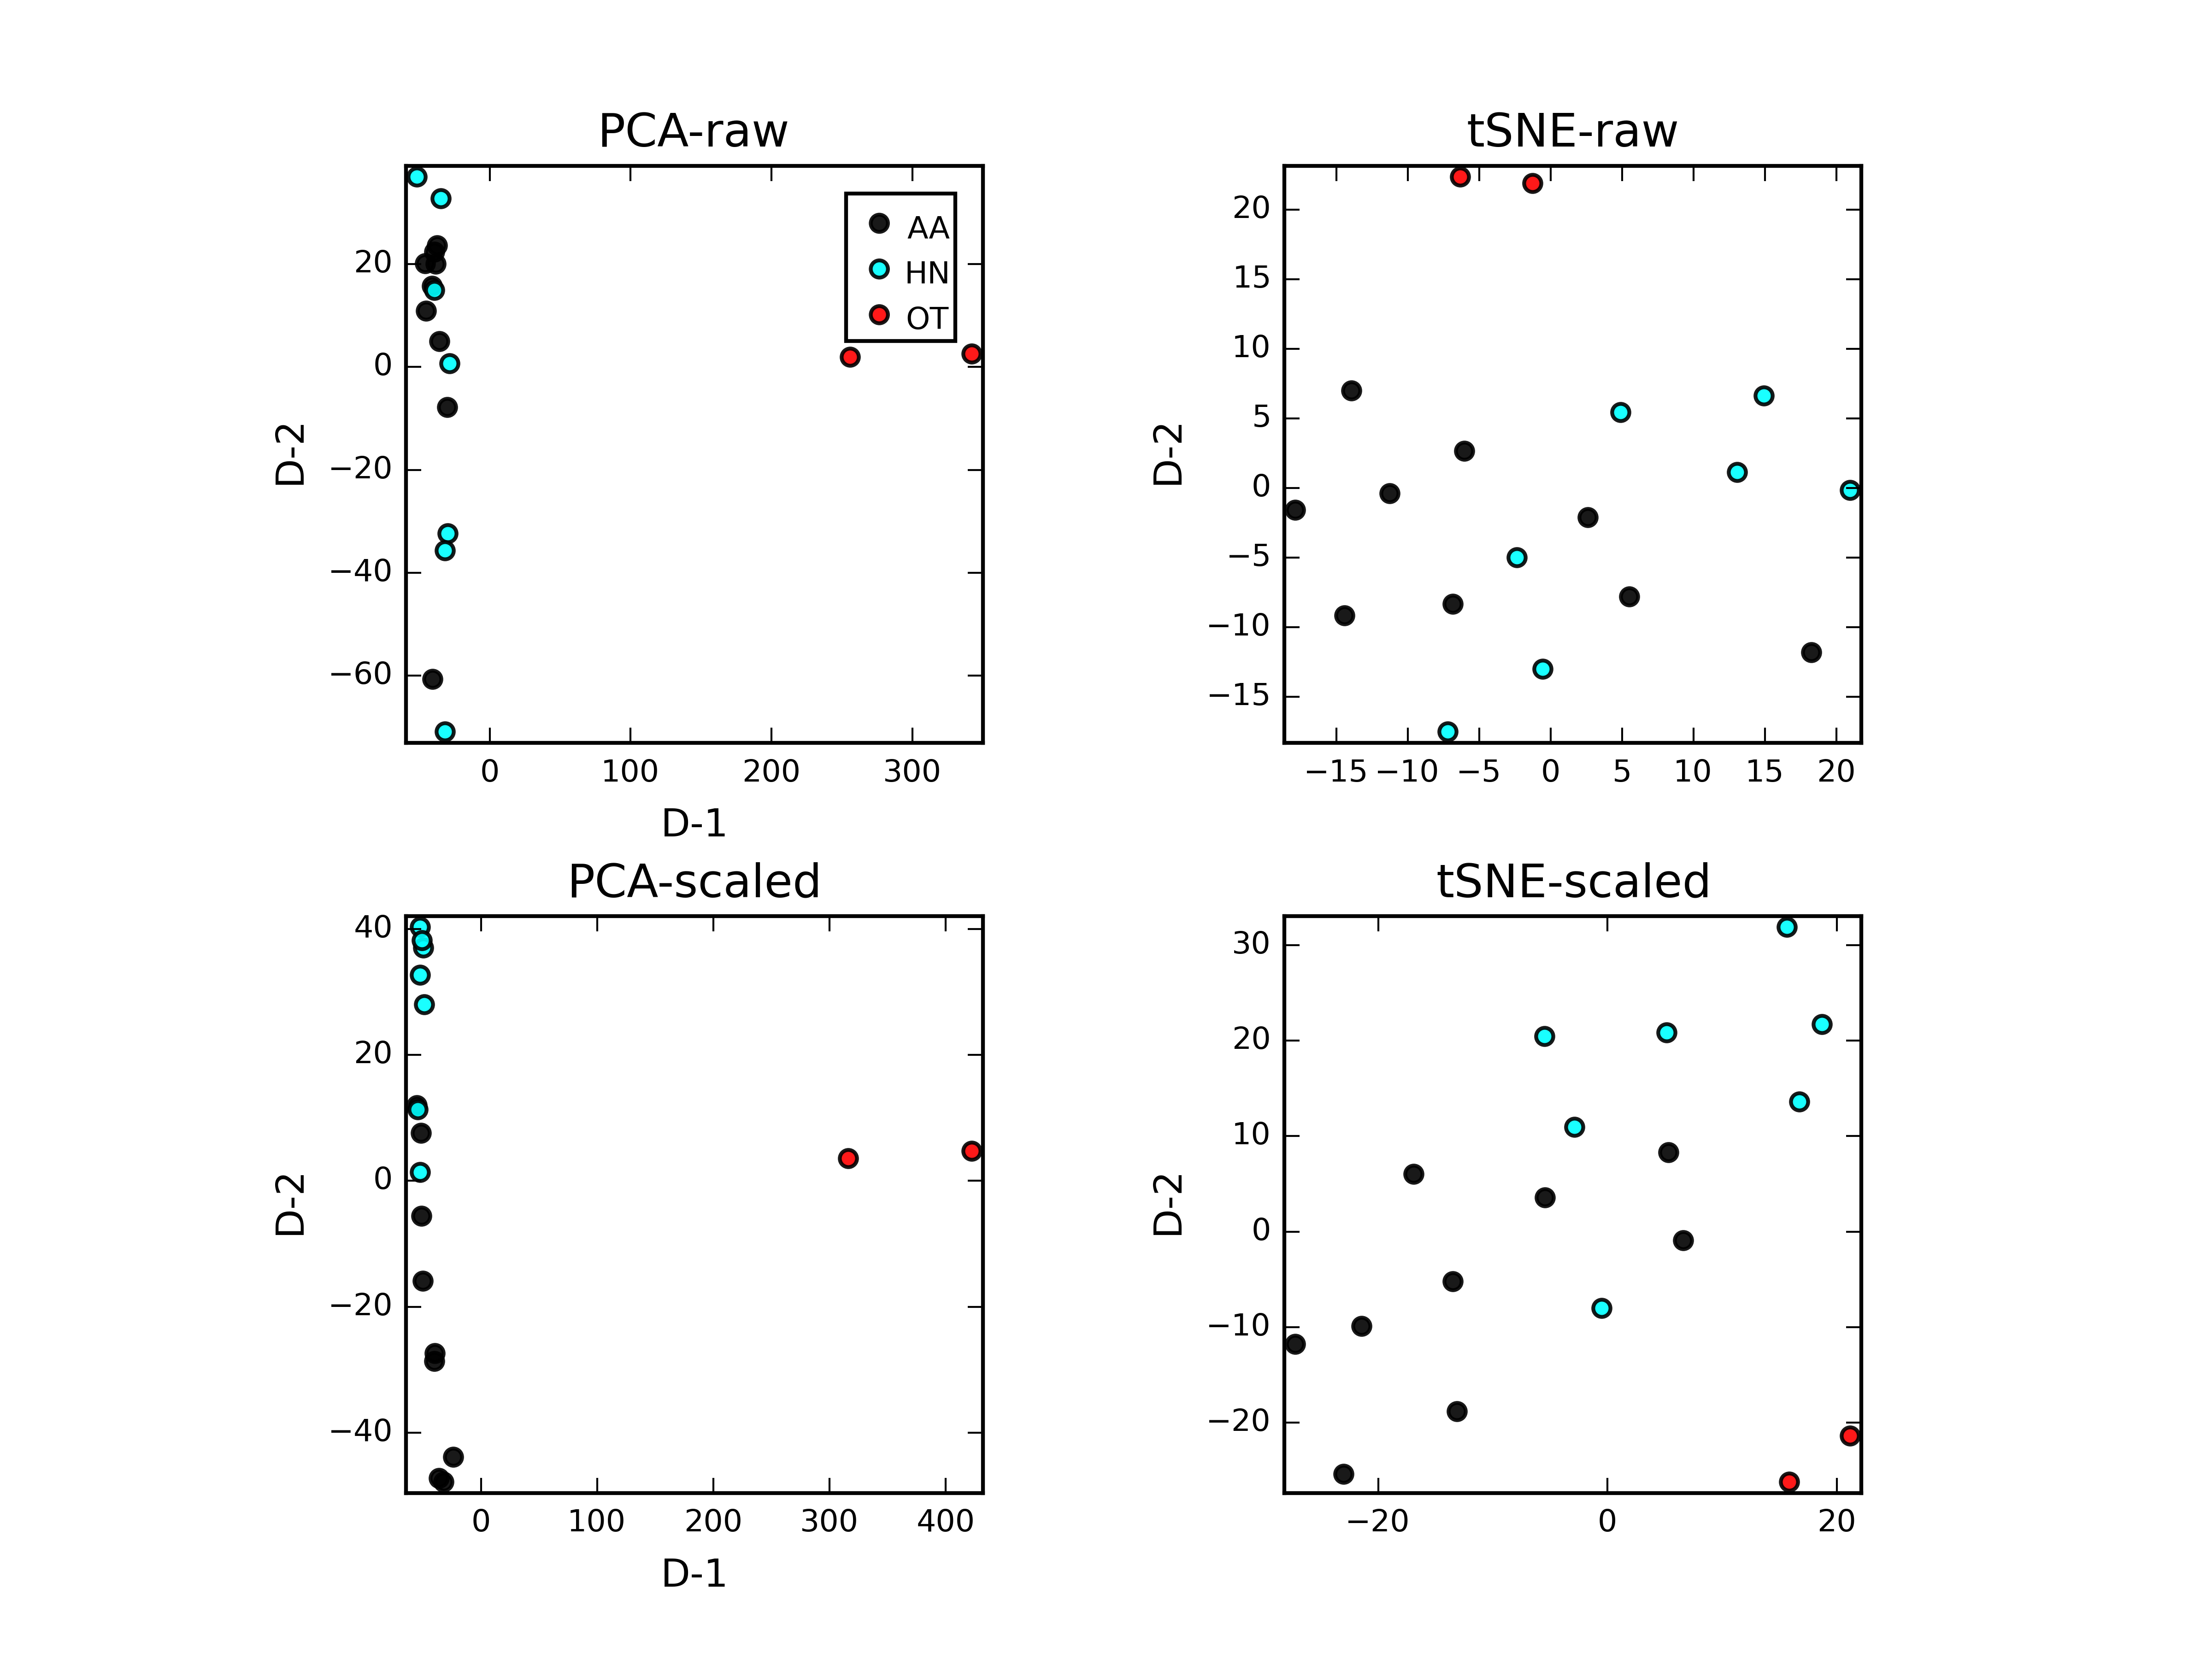

In [16]:
Image(filename='outliers-projection.png')

Because we are not that interested in relative fold change differences, i.e. we do not want the scale of expression differences to dominate the projection we use a standarization.  Based on these plot it appears that PCA does a better job than tSNE of separating outliers.  Depending on how far we put the outliers it is often the case that PCA does better when scaled, but tSNE performs better when using the original data.
Run the outlier algorithm
---------------------------

This comes from the [scikit-learn example](http://scikit-learn.org/stable/auto_examples/covariance/plot_outlier_detection.html#example-covariance-plot-outlier-detection-py)


In [17]:
from IPython.display import Image
outliers_fraction = 0.15
classifiers = {"robust covariance estimator": EllipticEnvelope(contamination=outliers_fraction)}


def make_subplot_again(X,covs,covariate,ax,pcX=0,pcY=1,fontSize=10,fontName='sans serif',ms=20,leg=True,title=None):

    ## variables
    colors = ['k','cyan','r','orange','g','b','magenta']
    clf_name = "robust covariance estimator"
    clf = EllipticEnvelope(contamination=.1)
    X =preprocessing.scale(X.copy())
    
    ## figure out scale
    buff = 0.02
    bufferX = buff * (X[:,pcX].max() - X[:,pcX].min())
    bufferY = buff * (X[:,pcY].max() - X[:,pcY].min())
    mm = [(X[:,pcX].min()-bufferX,X[:,pcX].max()+bufferX),(X[:,pcY].min()-bufferY,X[:,pcY].max()+bufferY)]
    xx, yy = np.meshgrid(np.linspace(mm[0][0],mm[0][1], 500), np.linspace(mm[1][0],mm[1][1],500))
    
    # fit the data and tag outliers
    clf.fit(X)
    y_pred = clf.decision_function(X).ravel()
    threshold = stats.scoreatpercentile(y_pred,100 * outliers_fraction)
    
    y_pred = y_pred > threshold
    print y_pred
    
    # plot the levels lines and the points
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    ax.contourf(xx, yy, Z, levels=np.linspace(Z.min(), threshold, 7),cmap=plt.cm.Blues_r)
    a = ax.contour(xx, yy, Z, levels=[threshold],linewidths=2, colors='red')
    ax.contourf(xx, yy, Z, levels=[threshold, Z.max()],colors='orange')
    ax.axis('tight')
   
    cvNames = np.sort(np.unique(covs[covariate]))
    lines = []
    for _i,i in enumerate(cvNames):
        indices = np.where(covs[covariate]==i)[0]
        s = ax.scatter(X[indices,pcX],X[indices,pcY],c=colors[_i],s=ms,label=covariate,alpha=0.9)
        lines.append(s)

    ## axes
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(fontSize-2)
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(fontSize-2)

    ax.set_xlabel("D-%s"%str(pcX+1),fontsize=fontSize,fontname=fontName)
    ax.set_ylabel("D-%s"%str(pcY+1),fontsize=fontSize,fontname=fontName)
    plt.locator_params(axis='x',nbins=5)
    ax.set_aspect(1./ax.get_data_ratio())
    ax.set_xlim(mm[0])
    ax.set_ylim(mm[1])
 
    if title:
        ax.set_title(title,fontsize=fontSize+2,fontname=fontName)
    if leg:
        legend = ax.legend(lines,cvNames,loc='upper right',scatterpoints=1,
                           handletextpad=0.01,labelspacing=0.01,borderpad=0.1,handlelength=1.0)

        for label in legend.get_texts():
            label.set_fontsize(fontSize-2)
            label.set_fontname(fontName)

## make the figure again
plt.clf()
fig = plt.figure()
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)
make_subplot_again(fit1,covs,'phenotype',ax1,pcX=0,pcY=1,leg=True,title='PCA-raw')
make_subplot_again(fit2,covs,'phenotype',ax2,pcX=0,pcY=1,leg=False,title='tSNE-raw')
make_subplot_again(fit3,covs,'phenotype',ax3,pcX=0,pcY=1,leg=False,title='PCA-scaled')
make_subplot_again(fit4,covs,'phenotype',ax4,pcX=0,pcY=1,leg=False,title='tSNE-scaled')
ax1.set_xlabel("")
ax2.set_xlabel("")
ax2.set_ylabel("")
ax4.set_ylabel("")
plt.subplots_adjust(hspace=0.3,wspace=0.05)
plt.savefig("outliers-detection.png",dpi=600)


[ True False  True  True  True  True  True  True  True  True  True  True
  True  True  True  True False False]
[ True False  True  True  True  True  True  True  True  True  True  True
  True  True  True  True False False]
[False  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True False False]
[ True False  True  True  True  True  True  True  True  True  True  True
  True  True  True  True False False]


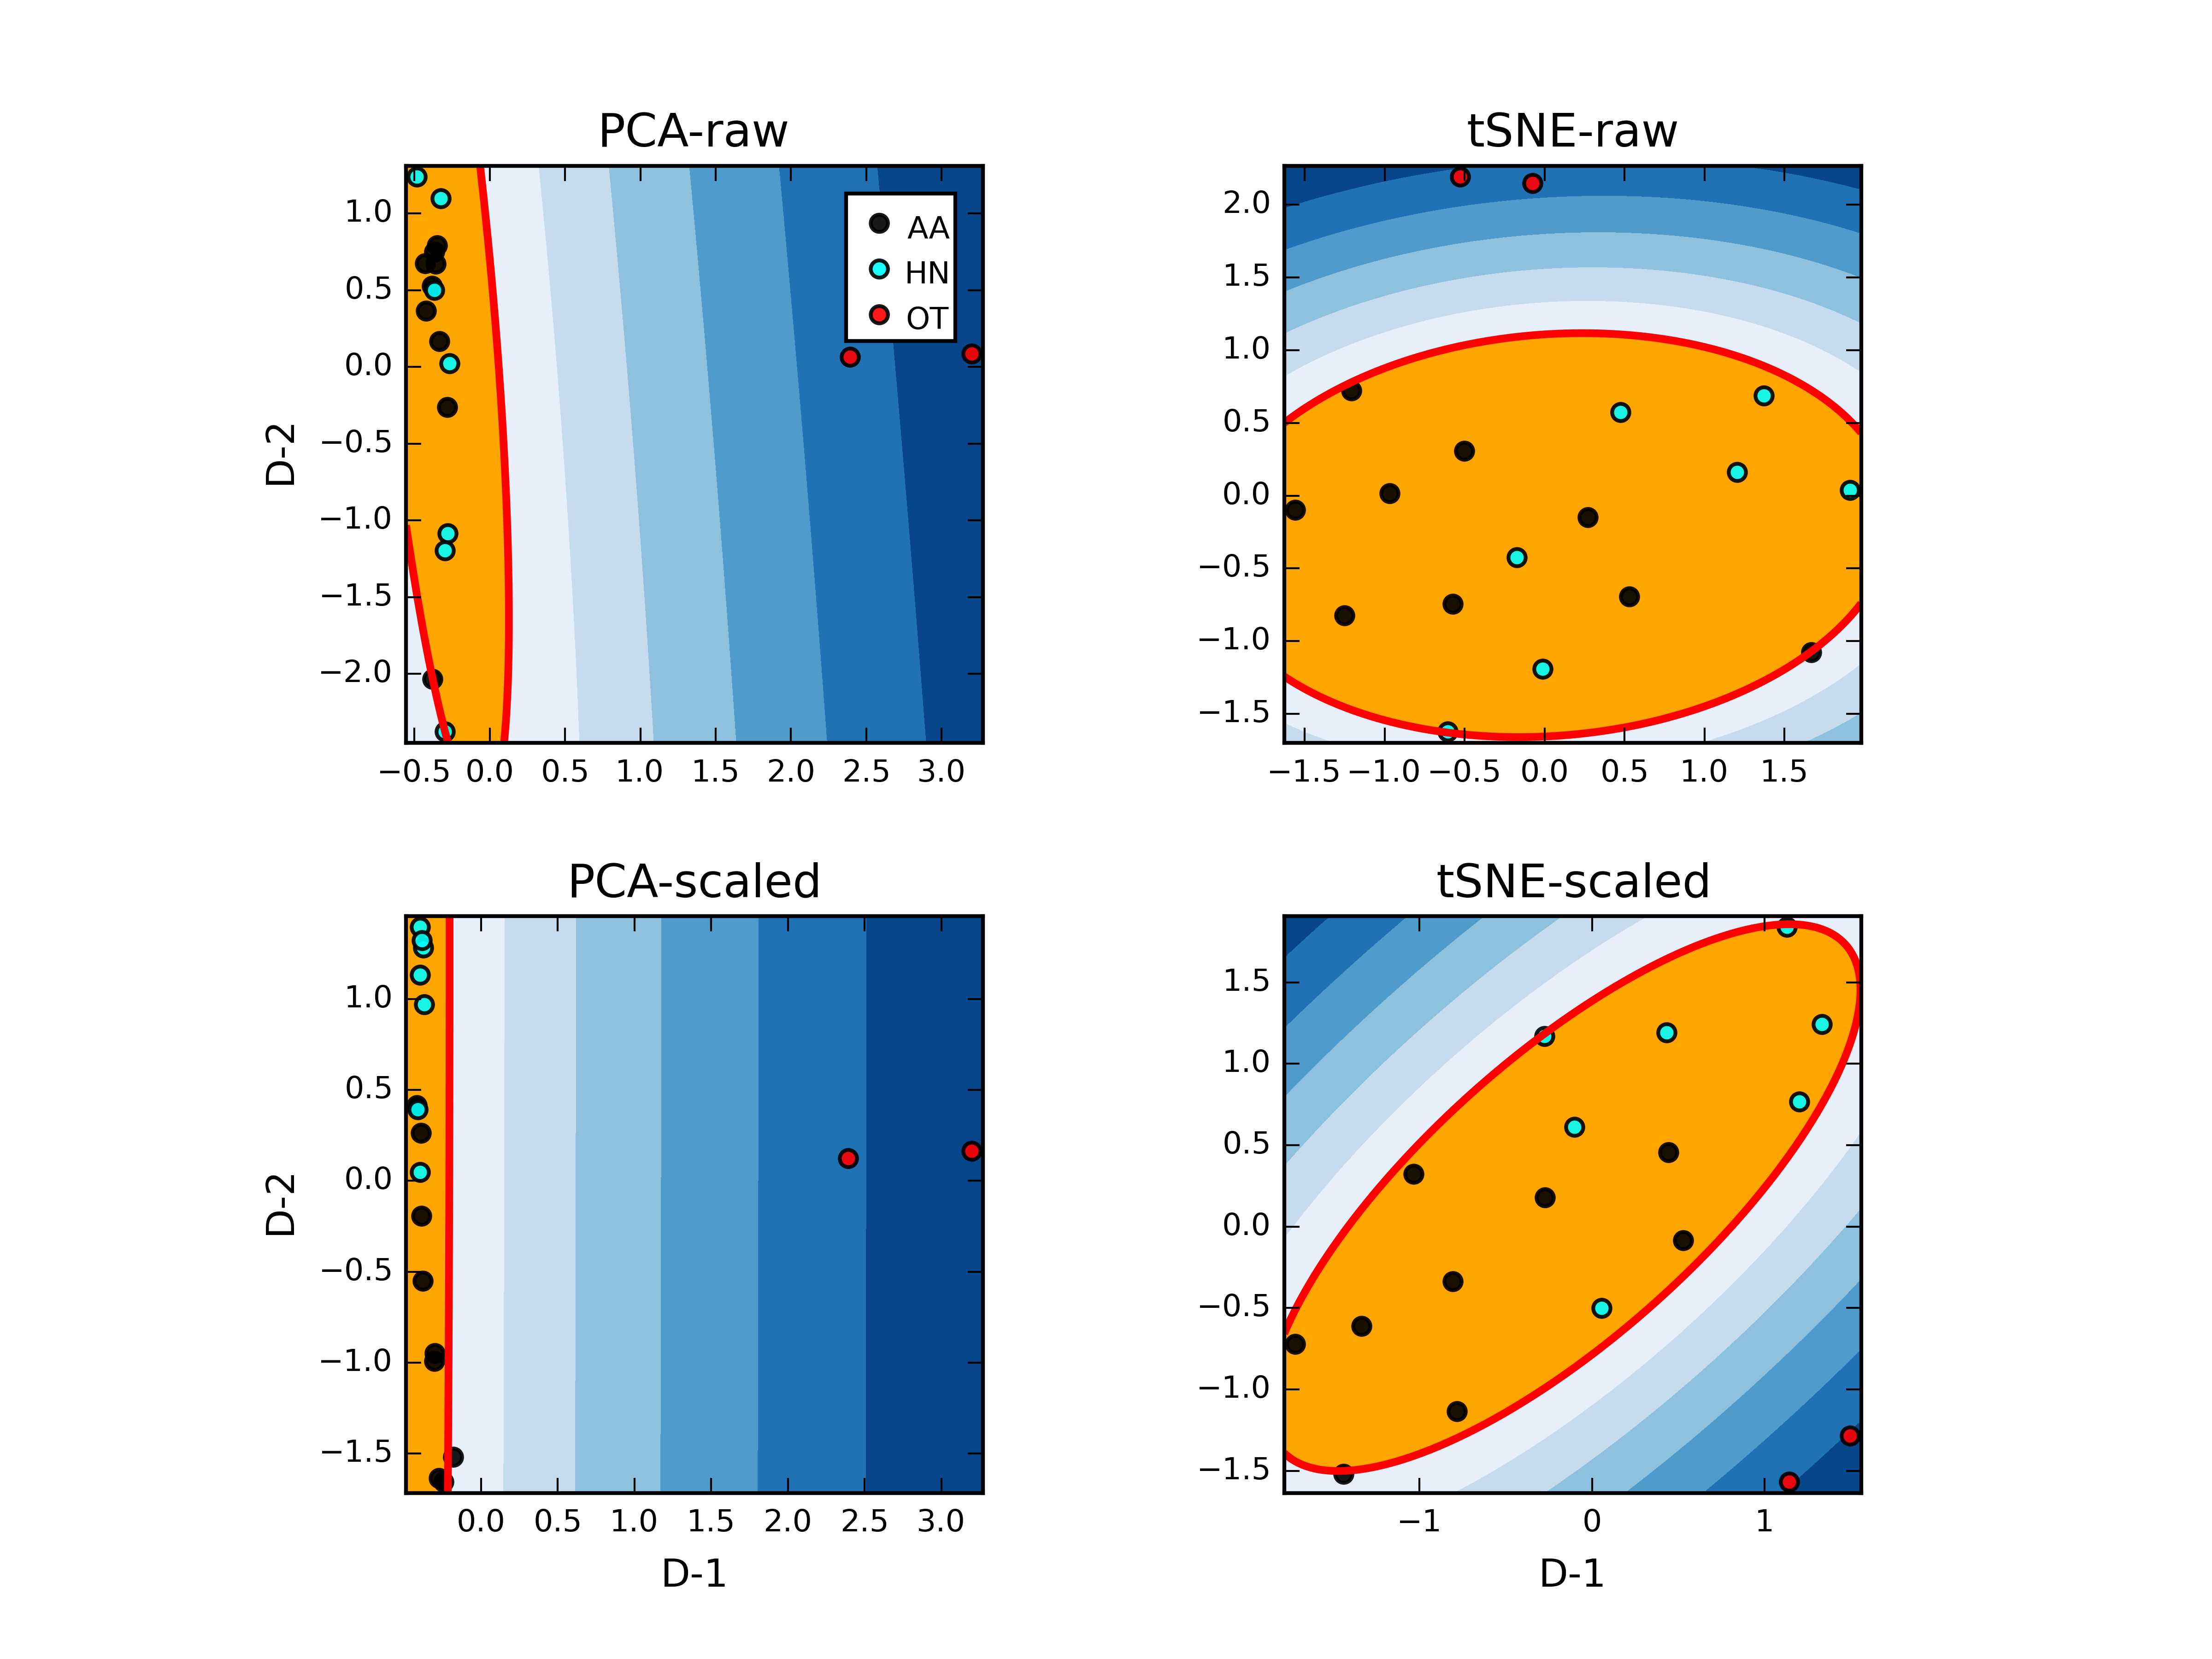

In [18]:
Image(filename='outliers-detection.png')

Discussion
------------------------
The method appears to work fairly well.  Care needs to be taken on which project method and whether or not the results need to be scaled, but for the most part the results are the same.